In [1]:
import numpy as np
import pickle
import healpy as hp
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/kristen/Documents/GitHub/NILC-Inference-Pipeline/shared')
sys.path.append('/Users/kristen/Documents/GitHub/NILC-Inference-Pipeline/analytic_model')

In [2]:
import os
import subprocess
import pickle
import time
from input import Info
from generate_maps import generate_freq_maps
from load_weight_maps import load_wt_maps
from utils import setup_output_dir, tsz_spectral_response, GaussianNeedlets, build_NILC_maps

In [3]:
font = {'size'   : 20, 'family':'STIXGeneral'}
plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':20})
plt.rc_context({'axes.autolimit_mode': 'round_numbers'})

### To run this notebook, first run main.py with save_files=1 in the yaml file. The variable save_dir below should be the directory in which to save the plots (set save_dir=None if you don't want to save the plots).

In [4]:
save_dir = 'plots'
sim = 0


## Read input yaml file

In [5]:
# main input file containing most specifications 
input_file = '/Users/kristen/Documents/GitHub/NILC-Inference-Pipeline/analytic_model/laptop.yaml'

# read in the input file and set up relevant info object
inp = Info(input_file)

## Sample input maps and power spectra

saved plots/input_maps.pdf


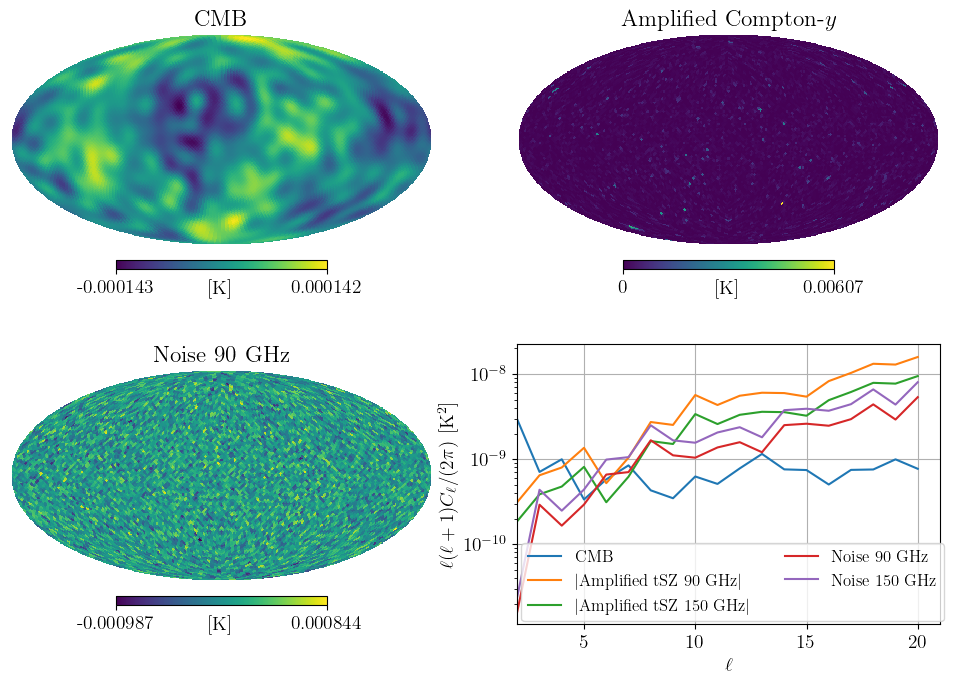

In [6]:
cmb_cl, tsz_cl, noise_cl, cmb_map, tsz_map, noise_map = generate_freq_maps(sim, inp, save=False)
ells_sum = np.arange(inp.ell_sum_max+1)

g_cmb = np.array([1., 1.])
g_tsz = tsz_spectral_response(inp.freqs)

fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()
margins=None #(1,1,1,1)

plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':14})

for n, ax in enumerate(axs):
    plt.axes(ax)
    if n==0:
        hp.mollview(cmb_map, fig=1, hold=True, title='CMB', format='%.03g')
    elif n==1:
        hp.mollview(tsz_map, fig=2, hold=True, title=r'Amplified Compton-$y$', format='%.03g')
    elif n==2:
        hp.mollview(noise_map, fig=3, hold=True, title='Noise 90 GHz', format='%.03g')
    else:
        to_dl = ells_sum*(ells_sum+1)/2/np.pi
        plt.plot(ells_sum[2:], (to_dl*cmb_cl)[2:], label='CMB')
        plt.plot(ells_sum[2:], abs(to_dl*g_tsz[0]*tsz_cl)[2:], label=r'$|$Amplified tSZ 90 GHz$|$', linestyle='solid')
        plt.plot(ells_sum[2:], abs(to_dl*g_tsz[1]*tsz_cl)[2:], label=r'$|$Amplified tSZ 150 GHz$|$', linestyle='solid')
        plt.plot(ells_sum[2:], (to_dl*noise_cl)[2:], label='Noise 90 GHz', linestyle='solid')
        plt.plot(ells_sum[2:], (to_dl*1.5*noise_cl)[2:], label='Noise 150 GHz', linestyle='solid')
        plt.xlabel(r'$\ell$', fontsize=14)
        plt.ylabel(r'$\ell(\ell+1)C_{\ell}/(2\pi)$ [$\mathrm{K}^2$]', fontsize=14)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.grid()
        plt.legend(fontsize=12, ncol=2, loc=(0.01,0.01))
        plt.yscale('log')
        plt.xlim(2,inp.ell_sum_max+1)
    if n==0 or n==1 or n==2:
        plt.text(0.47, -0.02, r'$[\mathrm{K}]$', transform=ax.transAxes,size=14)

if save_dir:
    plt.savefig(f'{save_dir}/input_maps.pdf')
    print(f'saved {save_dir}/input_maps.pdf')


plt.rcParams.update({
     'text.usetex': True,
     'font.family': 'serif',
     'font.sans-serif': ['Computer Modern'],
     'font.size':20})

## Needlet filters

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


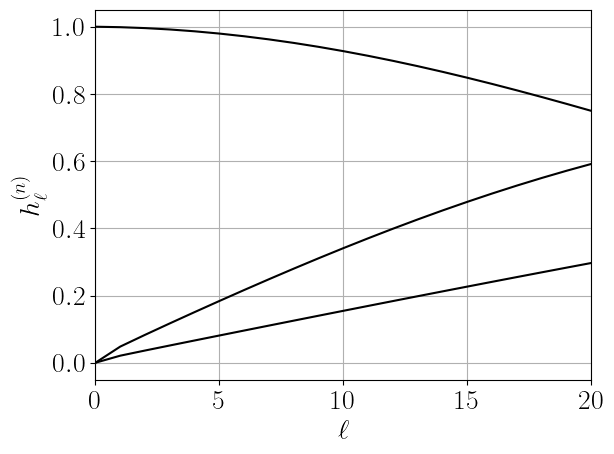

In [7]:
ells_sum, h = GaussianNeedlets(inp)
for n in range(inp.Nscales):
    plt.plot(ells_sum, h[n], color='k')
plt.grid()
plt.xlim(0,inp.ell_sum_max)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$h_\ell^{(n)}$')
# if save_dir:
#     plt.savefig(f'{save_dir}/needlet_filters.pdf')
#     print(f'saved {save_dir}/needlet_filters.pdf')

#check that sum of (h^n_ell)^2=1 at each ell
print(np.einsum('nl,nl->l', h, h))

## Weight maps for preserved CMB component

In [8]:
CMB_wt_maps, tSZ_wt_maps = load_wt_maps(inp, sim)

saved plots/weight_maps.pdf


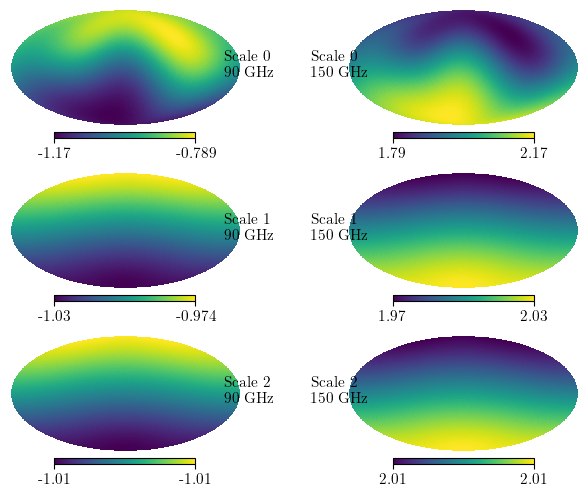

In [9]:
plt.rcParams.update({'font.size':11})

fig, axs = plt.subplots(inp.Nscales, len(inp.freqs), figsize=(8,6))
axs = axs.flatten()

ax = 0
for n in range(inp.Nscales):
    for i in range(len(inp.freqs)):
        plt.axes(axs[ax])
        hp.mollview(CMB_wt_maps[n][i], hold=True, title='', format='%.03g')
        if i == 0:
            plt.text(0.85, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        elif i == 1:
            plt.text(-0.04, 0.5, f'Scale {n}\n{int(inp.freqs[i])} GHz', transform=axs[ax].transAxes,size=11)
        ax += 1

if save_dir:
    plt.savefig(f'{save_dir}/weight_maps.pdf')
    print(f'saved {save_dir}/weight_maps.pdf')
    
plt.rcParams.update({'font.size':20})

## Component propagation to NILC map (comparing analytic and directly calculated results)

In [10]:
def build_NILC_maps_here(inp, sim, h, CMB_wt_maps, tSZ_wt_maps, freq_maps=None):
    '''
    Note that pyilc checks which frequencies to use for every filter scale
    We include all freqs for all filter scales here

    ARGUMENTS
    ---------
    inp: Info object containing input parameter specifications
    sim: int, simulation number
    h: (N_scales, ellmax+1) ndarray containing needlet filters at each scale
    CMB_wt_maps: (Nscales, Nfreqs=2, npix (variable for each scale and freq)) nested list,
                contains NILC weight maps for preserved CMB
    tSZ_wt_maps: (Nscales, Nfreqs=2, npix (variable for each scale and freq)) nested list,
                contains NILC weight maps for preserved tSZ
    freq_maps: (Nfreqs=2, 12*nside**2) ndarray containing simulated map at 
                each frequency to use in NILC map construction

    RETURNS
    -------
    NILC_maps: (2 for CMB or tSZ preserved NILC map, 12*nside**2) ndarray
    '''

    if freq_maps is None:
        freq_map1 = hp.read_map(f'{inp.output_dir}/maps/sim{sim}_freq1.fits')
        freq_map2 = hp.read_map(f'{inp.output_dir}/maps/sim{sim}_freq2.fits')
        freq_maps = [freq_map1, freq_map2]
    
    NILC_maps = []
    for p in range(2):
        if p==0:
            wt_maps = CMB_wt_maps
        else:
            wt_maps = tSZ_wt_maps
        all_maps = np.zeros((inp.Nscales, 12*inp.nside**2)) #index as all_maps[scale][pixel]
        for i in range(len(inp.freqs)):
            map_ = freq_maps[i]
#             map_ = hp.ud_grade(map_, inp.nside) #changed
            alm_orig = hp.map2alm(map_) #changed
            for n in range(inp.Nscales):
                alm = hp.almxfl(alm_orig, h[n]) #initial needlet filtering
                map_ = hp.alm2map(alm, inp.nside)
                NILC_weights = hp.ud_grade(wt_maps[n][i],inp.nside)
                map_ = map_*NILC_weights #application of weight map
                all_maps[n] = np.add(all_maps[n], map_) #add maps at all frequencies for each scale
        T_ILC_n = None
        for n in range(inp.Nscales):
            T_ILC_alm = hp.map2alm(all_maps[n]) #changed
            tmp = hp.almxfl(T_ILC_alm, h[n]) #final needlet filtering
            if T_ILC_n is None:
                T_ILC_n = np.zeros((inp.Nscales,len(tmp)),dtype=np.complex128)
            T_ILC_n[n]=tmp
        T_ILC = np.sum(np.array([hp.alm2map(T_ILC_n[n], inp.nside) for n in range(len(T_ILC_n))]), axis=0) #adding maps from all scales
        NILC_maps.append(T_ILC)
    return freq_maps
#     return NILC_maps

saved plots/propagation.pdf


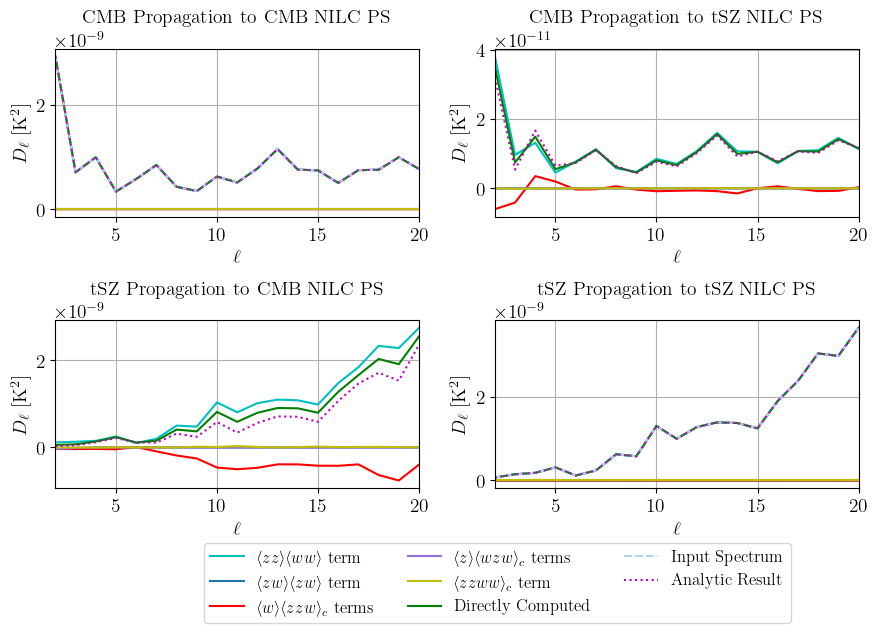

In [15]:
plt.rcParams.update({'font.size':14})

#index as directly_computed_prop_to_NILC_PS[z,p,l]
directly_computed_prop_to_NILC_PS = pickle.load(open(f'{inp.output_dir}/data_vecs/sim{sim}_directly_computed_prop_to_NILC_PS.p', 'rb'))

#index as Clpq[p,q,z,reMASTERed term,l]
Clpq = pickle.load(open(f'{inp.output_dir}/data_vecs/sim{sim}_Clpq.p', 'rb'))

#index as 0-2 for CMB, tSZ, noise
Clzz = pickle.load(open(f'{inp.output_dir}/n_point_funcs/sim{sim}_Clzz.p', 'rb'))


# #remove section below and uncomment above once there are results
# directly_computed_prop_to_NILC_PS = np.ones((2,2,inp.ellmax+1))
# Clpq = 0.5*np.ones((2,2,2,5,inp.ellmax+1))

comps = ['CMB', 'tSZ']

ells = np.arange(inp.ellmax+1)
start = 2

fig, axs = plt.subplots(2,2, figsize=(9,6))
axs = axs.flatten()
ax = 0
for z, prop_comp in enumerate(comps):
    for p, preserved_comp in enumerate(comps):
        plt.axes(axs[ax])
        direct = directly_computed_prop_to_NILC_PS[z,p]
        remastered_terms = Clpq[p,p,z]
        analytic = np.sum(remastered_terms, axis=0)
        aa_ww_term, aw_aw_term, w_aaw_term, a_waw_term, aaww_term = remastered_terms
        plt.plot(ells[start:], (ells*(ells+1)*aa_ww_term/(2*np.pi))[start:], label=r'$\langle zz \rangle \langle ww \rangle$ term', color='c')
        plt.plot(ells[start:], (ells*(ells+1)*aw_aw_term/(2*np.pi))[start:], label=r'$\langle zw \rangle \langle zw \rangle$ term')
        plt.plot(ells[start:], (ells*(ells+1)*w_aaw_term/(2*np.pi))[start:], label=r'$\langle w \rangle \langle zzw \rangle_c$ terms', color='r')
        plt.plot(ells[start:], (ells*(ells+1)*a_waw_term/(2*np.pi))[start:], label=r'$\langle z \rangle \langle wzw \rangle_c$ terms', color='mediumpurple')
        plt.plot(ells[start:], (ells*(ells+1)*aaww_term/(2*np.pi))[start:], label=r'$\langle zzww \rangle_c$ term', color='y')
        plt.plot(ells[start:], (ells*(ells+1)*direct/(2*np.pi))[start:], label='Directly Computed', color='g')
        if ax==0:
            plt.plot(ells[start:], (ells*(ells+1)*cmb_cl/(2*np.pi))[start:], label='Input Spectrum', linestyle='dashed', color='lightblue')
        elif ax==3:
            plt.plot(ells[start:], (ells*(ells+1)*tsz_cl/(2*np.pi))[start:], label='Input Spectrum', linestyle='dashed', color='lightblue')
        plt.plot(ells[start:], (ells*(ells+1)*analytic/(2*np.pi))[start:], label='Analytic Result', linestyle='dotted', color='m')
        plt.xlabel(r'$\ell$')
        plt.ylabel(r'$D_\ell$ $[\mathrm{K}^2]$')
        plt.grid()
        plt.xlim(2,inp.ellmax)
#         plt.title(f'{comps[z]} Propagation to \n{comps[p]} NILC Power Spectrum', fontsize=14)
        plt.title(f'{comps[z]} Propagation to {comps[p]} NILC PS', fontsize=14)
        ax += 1
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=12, bbox_to_anchor=(0.9, 0.04), ncol=3)
plt.tight_layout()
fig = plt.gcf()
fig.subplots_adjust(top=0.85)

if save_dir:
    plt.savefig(f'{save_dir}/propagation.pdf', bbox_inches='tight')
    print(f'saved {save_dir}/propagation.pdf')

plt.rcParams.update({'font.size':20})



In [19]:
tsz_cl/np.sum(Clpq[1,1,1], axis=0)

array([ 1.75049218,  3.69800234,  3.91419479,  4.15145139,  4.41231659,
        4.69961801,  5.01654591,  5.36672786,  5.75430726,  6.18400951,
        6.66123422,  7.19216743,  7.7839013 ,  8.44458738,  9.18358775,
       10.01170146, 10.94138695, 11.98703264, 13.16529075, 14.4954627 ,
       15.99995676])

## Heat map example (shows coupling across scales)

## Acmb and Atsz plots for template-fitting and NILC